# Part 1 - Sentence Decoding 

## Analyze with word2vec embeddings

### Get Word2vec Results

In [1]:
# # Download and extract the data and learn_decoder.py
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56" -O files.zip && rm -rf /tmp/cookies.txt
# !unzip files.zip
# !rm files.zip

In [ ]:
import numpy as np
from gensim import downloader

#Let's load the functions from learn_decoder.py
from learn_decoder import *

#and the data
data = read_matrix("imaging_data.csv", sep=",") 
concepts = np.genfromtxt('stimuli_180concepts.txt', dtype=np.dtype('U')) #The names of the 180 concepts

In [ ]:
embedding_model = downloader.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
vectors = np.zeros([180, 300])
for i, word in enumerate(concepts):
  if word in embedding_model.key_to_index.keys():
    vectors[i] = embedding_model.key_to_index[word]
  else:
    print(f"{i, word} is not exist in word2vec dict keys")

(6, 'argumentatively') is not exist in word2vec dict keys


In [ ]:
vectors[6] = embedding_model.key_to_index["argumentative"]

In [ ]:
# Saving the array
np.savetxt("vectors_by_word2vec.csv", vectors, delimiter=",")

In [ ]:
# Reading the csv into an array
vectors = np.genfromtxt("vectors_by_word2vec.csv", delimiter=",")

In [ ]:
type(data)

numpy.ndarray

#### Calc M, Ranks and Accuracy

In [ ]:
def cosine_similarity(x: np.ndarray, y: np.ndarray) -> float:
  similarity = x.dot(y) / (np.linalg.norm(x) * np.linalg.norm(y))
  return(similarity) ## TODO: replace this with an implementation of cosine similarity.
  
def get_rank(pred_vec, vec_index, test_vectors, train_vectors):
  simlarity_dict = {}
  all_vectors = np.concatenate((test_vectors, train_vectors), axis=0)

  for j, test_vec in enumerate(all_vectors):
    sim = cosine_similarity(pred_vec, test_vec)
    simlarity_dict[j] = sim
  sorted_sim = sorted(simlarity_dict.items(), key=lambda x:x[1], reverse=True)

  for rank, (test_train_index, sim) in enumerate(sorted_sim):
    if test_train_index == vec_index:
      return(rank + 1)

import random

def rank_based_accuracy(train_data, test_data, train_vectors, test_vectors, test_idx):
  train_M = learn_decoder(train_data, train_vectors)
  pred_vectors = np.matmul(test_data, train_M)
  rank_list = []
  poor_rank_idx = []
  high_rank_idx = []
  extremely_high_idx = []
  for vec_index, pred_vec in enumerate(pred_vectors):
    rank = get_rank(pred_vec, vec_index, test_vectors, train_vectors)
    rank_list.append(rank)

    original_idx = test_idx[vec_index]
    if rank >= 165:
      poor_rank_idx.append(original_idx)
    if rank <= 15:
      high_rank_idx.append(original_idx)
    if rank <= 5:
      extremely_high_idx.append(original_idx)

  print(f"{rank_list=}")
  accuracy = np.mean(rank_list)
  return accuracy, poor_rank_idx, high_rank_idx, extremely_high_idx

def main(data, k=18):
  random.seed(42)
  #split the data
  group_size = int(data.shape[0]/k)
  all_idx = list(range(data.shape[0]))
  random.shuffle(all_idx)
  groups = [all_idx[i:i+group_size] for i in range(0, len(all_idx), group_size)]
  # print(groups)

  accuracy_list = []
  all_poor_idx = []
  all_high_idx = []
  all_extremely_high_idx = []

  for test_idx in groups:
    # print("-----")
    # print(f"{test_idx=}")
    train_idx = list(set(all_idx) - set(test_idx))
    test_data = np.take(data, test_idx, axis=0)
    train_data = np.take(data, train_idx, axis=0)
    test_vectors = np.take(vectors, test_idx, axis=0)
    train_vectors = np.take(vectors, train_idx, axis=0)

    print("-----")
    accuracy, poor_rank_idx, high_rank_idx, extremely_high_idx = rank_based_accuracy(train_data, test_data, train_vectors, test_vectors, test_idx)

    accuracy_list.append(round(accuracy, 3))
    all_poor_idx = all_poor_idx + poor_rank_idx
    all_high_idx = all_high_idx + high_rank_idx
    all_extremely_high_idx = all_extremely_high_idx + extremely_high_idx


  print(f"{accuracy_list=}")
  print(f"avg accuracy over all data: {round(np.mean(accuracy_list), 3)}")
  return accuracy_list, all_poor_idx, all_high_idx, all_extremely_high_idx

### Print results

In [ ]:
accuracy_list, all_poor_idx, all_high_idx, all_extremely_high_idx = main(data, k=18)

-----
rank_list=[23, 119, 34, 164, 124, 5, 70, 11, 2, 124]
-----
rank_list=[100, 166, 26, 112, 108, 113, 48, 68, 173, 111]
-----
rank_list=[114, 75, 31, 180, 91, 167, 39, 18, 80, 164]
-----
rank_list=[30, 132, 121, 1, 126, 143, 149, 10, 92, 9]
-----
rank_list=[68, 53, 97, 92, 115, 84, 30, 81, 31, 114]
-----
rank_list=[142, 95, 37, 40, 92, 133, 147, 99, 147, 139]
-----
rank_list=[23, 23, 42, 162, 137, 64, 149, 106, 163, 10]
-----
rank_list=[30, 30, 167, 84, 53, 27, 75, 88, 49, 65]
-----
rank_list=[56, 113, 108, 122, 12, 143, 42, 172, 63, 73]
-----
rank_list=[5, 88, 114, 29, 11, 161, 109, 93, 76, 15]
-----
rank_list=[124, 50, 163, 72, 75, 3, 91, 171, 160, 93]
-----
rank_list=[135, 8, 26, 52, 3, 100, 20, 75, 48, 169]
-----
rank_list=[135, 91, 92, 129, 29, 170, 80, 2, 119, 27]
-----
rank_list=[12, 92, 122, 25, 22, 52, 67, 48, 47, 7]
-----
rank_list=[68, 31, 154, 92, 86, 76, 133, 38, 140, 175]
-----
rank_list=[147, 161, 80, 176, 174, 161, 96, 7, 111, 80]
-----
rank_list=[36, 104, 161, 125, 

### Plot avg accuracy by fold

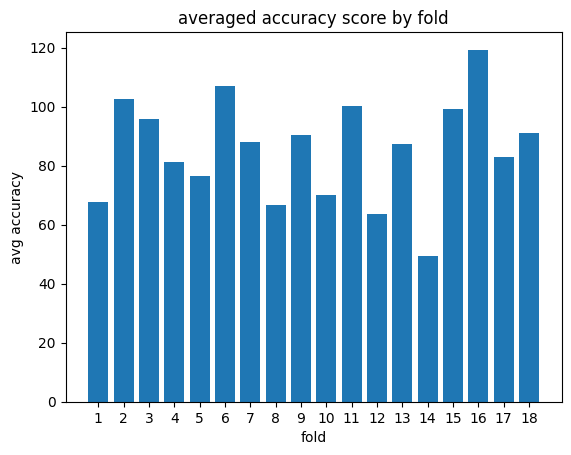

In [ ]:
import matplotlib.pyplot as plt

plt.bar(list(range(1,19)), accuracy_list)
plt.title("averaged accuracy score by fold")
plt.xticks(list(range(1,19)))
plt.xlabel("fold")
plt.ylabel("avg accuracy")
plt.show()

### Print high and low ranked concepts

In [ ]:
print("Poor rank concepts names: (rank>=165)\n")
for poor_idx in all_poor_idx:
  print(concepts[poor_idx])

Poor rank concepts names: (rank>=165)

clothes
usable
left
sin
philosophy
money
invisible
news
charming
typical
sound
personality
charity


In [ ]:
print("Extremely high rank concepts names:  (rank<=5) \n")
for high_idx in all_extremely_high_idx:
  print(concepts[high_idx])

Extremely high rank concepts names:  (rank<=5) 

cook
elegance
mountain
sexy
king
illness
sell


In [ ]:
print("High rank concepts names:  (rank<=15) \n")
for high_idx in all_high_idx:
  print(concepts[high_idx])

High rank concepts names:  (rank<=15) 

cook
prison
elegance
mountain
ignorance
ability
read
play
sexy
word
broken
king
road
illness
sell
laugh
land
useless
art
music


In [ ]:
percenatge_excellent_ranked_conceps = round(len(all_extremely_high_idx) * 100 / 180) 
percentage_good_ranked_conceps = round(len(all_high_idx) * 100 / 180) 
percentage_bad_ranked_concepts = round(len(all_poor_idx) * 100 / 180) 

In [ ]:
print(f"{percenatge_excellent_ranked_conceps=}%")
print(f"{percentage_good_ranked_conceps=}%")
print(f"{percentage_bad_ranked_concepts=}%")

percenatge_excellent_ranked_conceps=4%
percentage_good_ranked_conceps=11%
percentage_bad_ranked_concepts=7%


### Compare Glove and Word2vec Results

Glove results:
* mean rank accuracy by all folds: 61.4
* percenatge_excellent_ranked_conceps=4%
* percentage_good_ranked_conceps=17%
* percentage_bad_ranked_concepts=3%

Word2Vec results:
* mean rank accuracy by all folds: 85.5
* percenatge_excellent_ranked_conceps=4%
* percentage_good_ranked_conceps=11%
* percentage_bad_ranked_concepts=7%

--> With Glove we get better results: higher mean rank accuracy over all concepts (61.4 vs 85.5, reminding that the lower the better) higher percentage of good ranked conceps (17% vs 11%) and lower percentage of bad ranked conceps (3% vs 7%).


----
Glove best ranked concepts (rank<=15):
* do, team, left, time, ability, picture, big, quality, crazy, skin, show, lady, food, play, money, feeling, hair, road, dinner, laugh, great, extremely, light, damage, stupid, relationship, dog, music, shape, construction, fish.

Word2Vec best ranked concepts (rank<=15):
*  cook, prison, elegance, mountain, ignorance, ability, read, play, sexy, word, broken, king, road, illness, sell, laugh, land, useless, art,music.

--> In both embeddings we get high rank to concepts that has "simple" meanings where most of the concepts are common words, most of them nouns (lady, dog, dinner, road, king etc.). somer concepts are more ambigious and we were surprised to see them in the top list, like ability, elegance and useless. But most of the words are simple and we were not surprised to see them in thosr lists.



----
Glove worse ranked concepts (rank>=165):
* deceive, electron, applause, cockroach ,argumentatively

Word2Vec worse ranked concepts (rank>=165):
* clothes, usable, left, sin, philosophy, money, invisible, news, charming, typical, sound, personality, charity

--> In both embeddings the concpets that got poor rank were words that might be less explicit and simple, like "applause", "argumwntatively", "usable", "typical". It make sense why such words are not decoded well, in comparison to very common and simple nouns like those we showed above.

---
Overall we can see that the Glove captures better the difference and the similaritirs of the concepts, so the decoding process was with more accurate results, than the results when using Word2Vec embeddings.

## Pereire paper - similarities and differences between analyzes 1,2,3

## Decode experiment 2 data, using Glove

### Get the Results

### Interpret Results

## Decode experiment 3 data, using Glove

### EXP3 data

#### unpack pickle

In [ ]:
import pickle

with open('EXP3.pkl', 'rb') as f:
    exp3_data = pickle.load(f)

UnpicklingError: ignored

In [ ]:
exp3_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'keyPassageCategory', 'keyPassages', 'keySentences', 'labelsPassageCategory', 'labelsPassageForEachSentence', 'labelsSentences', 'meta', 'Fmridata'])

In [ ]:
# keyPassageCategory - a list of all broad categories/topics 
# keyPassages - the names of the passages
# keySentences - the sentences (same as in stimuli_243sentences.txt  ) 
# labelsPassageCategory - The category/topic’s id for each passage
# labelsPassageForEachSentence - The passage’s ids for every sentence (each sentence comes from a specific passage. The id of each sentence in this list is the relevant passage’s id) 
# labelsSentences - The sentences’ ids
# Fmridata - The fMRI data organized in a matrix contains 243 rows (each row= a sentence) and 185866 columns (each column = a different voxel).


#### keyPassageCategory - a list of all broad categories/topics 

In [ ]:
keyPassageCategory = exp3_data["keyPassageCategory"]
len(keyPassageCategory[0]), keyPassageCategory[0][:10]

(24,
 array([array(['astronaut'], dtype='<U9'),
        array(['beekeeping'], dtype='<U10'),
        array(['blindness'], dtype='<U9'),
        array(['bone_fracture'], dtype='<U13'),
        array(['castle'], dtype='<U6'),
        array(['computer_graphics'], dtype='<U17'),
        array(['dreams'], dtype='<U6'), array(['gambling'], dtype='<U8'),
        array(['hurricane'], dtype='<U9'),
        array(['ice_cream'], dtype='<U9')], dtype=object))

#### keyPassages - the names of the passages

In [ ]:
keyPassages = exp3_data["keyPassages"]
len(keyPassages), keyPassages[0:10]

(72,
 array([[array(['beekeeping'], dtype='<U10')],
        [array(['beekeeping'], dtype='<U10')],
        [array(['beekeeping'], dtype='<U10')],
        [array(['dreams'], dtype='<U6')],
        [array(['dreams'], dtype='<U6')],
        [array(['dreams'], dtype='<U6')],
        [array(['gambling'], dtype='<U8')],
        [array(['gambling'], dtype='<U8')],
        [array(['gambling'], dtype='<U8')],
        [array(['hurricane'], dtype='<U9')]], dtype=object))

#### labelsPassageCategory - The category/topic’s id for each passage 

In [ ]:
labelsPassageCategory = exp3_data["labelsPassageCategory"]
len(labelsPassageCategory), labelsPassageCategory[:10]

(72,
 array([[2],
        [2],
        [2],
        [7],
        [7],
        [7],
        [8],
        [8],
        [8],
        [9]], dtype=uint8))

#### labelsPassageForEachSentence - The passage’s ids for every sentence (each sentence comes from a specific passage. The id of each sentence in this list is the relevant passage’s id) 

In [ ]:
labelsPassageForEachSentence = exp3_data["labelsPassageForEachSentence"]
len(labelsPassageForEachSentence), labelsPassageForEachSentence[:10]

(243,
 array([[1],
        [1],
        [1],
        [1],
        [2],
        [2],
        [2],
        [2],
        [3],
        [3]], dtype=uint8))

#### labelsSentences - The sentences’ ids

In [ ]:
labelsSentences = exp3_data["labelsSentences"]
len(labelsSentences), labelsSentences[:10]

(243,
 array([[ 1],
        [ 2],
        [ 3],
        [ 4],
        [ 5],
        [ 6],
        [ 7],
        [ 8],
        [ 9],
        [10]], dtype=uint8))

#### keySentences

In [ ]:
keySentences = exp3_data["keySentences"]
len(keySentences), keySentences[:4]

(243,
 array([[array(['Beekeeping encourages the conservation of local habitats.'],
               dtype='<U57')                                                 ],
        [array(["It is in every beekeeper's interest to conserve local plants that produce pollen."],
               dtype='<U81')                                                                         ],
        [array(['As a passive form of agriculture, it does not require that native vegetation be cleared to make way for crops.'],
               dtype='<U110')                                                                                                     ],
        [array(['Beekeepers also discourage the use of pesticides on crops, because they could kill the honeybees.'],
               dtype='<U97')                                                                                         ]],
       dtype=object))

In [ ]:
keySentences.shape

(243, 1)

In [ ]:
keySentences[0]

array([array(['Beekeeping encourages the conservation of local habitats.'],
             dtype='<U57')                                                 ],
      dtype=object)

#### FMRI data

In [ ]:
Fmridata = exp3_data["Fmridata"]
type(Fmridata), Fmridata.shape

(numpy.ndarray, (243, 185866))

#### get data and concepts

In [ ]:
import numpy as np
from gensim import downloader

#Let's load the functions from learn_decoder.py
from learn_decoder import *

ModuleNotFoundError: ignored

In [ ]:
fmri_data_exp3 = Fmridata 
vectors_exp3 = read_matrix("vectors_243sentences.GV42B300.average.txt", sep=" ")

In [ ]:
fmri_data_exp1 = read_matrix("imaging_data.csv", sep=",") 
vectors_exp1 = read_matrix("vectors_180concepts.GV42B300.txt", sep=" ")
concepts_exp1 = np.genfromtxt('stimuli_180concepts.txt', dtype=np.dtype('U')) #The names of the 180 concepts

In [ ]:
data.shape, vectors.shape

((243, 185866), (243, 300))

1. sentence (243)
2. passage (72)
3. topic (24)

### Decode functions

In [ ]:
# !!!! TODO: DEBUG BELOW !!!!

In [ ]:
def cosine_similarity(x: np.ndarray, y: np.ndarray) -> float:
  similarity = x.dot(y) / (np.linalg.norm(x) * np.linalg.norm(y))
  return(similarity) ## TODO: replace this with an implementation of cosine similarity.
  
def get_rank(pred_vec, vec_index, test_vectors, train_vectors):
  simlarity_dict = {}
  all_vectors = np.concatenate((test_vectors, train_vectors), axis=0)

  for j, test_vec in enumerate(all_vectors):
    sim = cosine_similarity(pred_vec, test_vec)
    simlarity_dict[j] = sim
  sorted_sim = sorted(simlarity_dict.items(), key=lambda x:x[1], reverse=True)

  for rank, (test_train_index, sim) in enumerate(sorted_sim):
    if test_train_index == vec_index:
      return(rank + 1)

import random

def rank_based_accuracy(train_data, test_data, train_vectors, test_vectors):
  train_M = learn_decoder(train_data, train_vectors)
  pred_vectors = np.matmul(test_data, train_M)
  rank_list = []
  poor_rank_idx = []
  high_rank_idx = []
  extremely_high_idx = []
  for vec_index, pred_vec in enumerate(pred_vectors):
    rank = get_rank(pred_vec, vec_index, test_vectors)
    rank_list.append(rank)

    original_idx = test_idx[vec_index]
    if rank >= 165:
      poor_rank_idx.append(original_idx)
    if rank <= 15:
      high_rank_idx.append(original_idx)
    if rank <= 5:
      extremely_high_idx.append(original_idx)

  print(f"{rank_list=}")
  accuracy = np.mean(rank_list)
  return accuracy, poor_rank_idx, high_rank_idx, extremely_high_idx

def train_and_test(train_data, test_data, train_vectors, test_vectors):
  all_poor_idx = []
  all_high_idx = []
  all_extremely_high_idx = []

  print("-----")
  accuracy, poor_rank_idx, high_rank_idx, extremely_high_idx = rank_based_accuracy(train_data, test_data, train_vectors, test_vectors)

  print(f"{accuracy_list=}")
  print(f"avg accuracy over all data: {round(np.mean(accuracy_list), 3)}")
  return accuracy_list, poor_rank_idx, high_rank_idx, extremely_high_idx

### Run Decoding and Evaluate

In [ ]:
accuracy_list, all_poor_idx, all_high_idx, all_extremely_high_idx = main(data, k=18)

### Interpret Results

Identify Topics with more or less seuccefull decoding

# Part 2 - Run and Analyze EXP2 with Contextualized Word Embedding Model

using both original embedding in the parper (Glove) and the contextual embedding --> concat?? or just compare??

# Part 2 - Build Brain Encoder

Instead of predicting sentence identities using neural
signals (i.e., neural decoding), we will try to predict human neural signals from the
embedding vectors representations of the sentences (neural encoding; you can read about neural encoder in Huth et al., 2016’s paper).

### fit a separate linearregression model for each voxel 

### Results with Glove embedding

For each voxel/model, calculate the R^2
score and examine how many voxels are significantly associated with the
information embedded in the word vectors,

Interpret how well those voxels are predicted

---

### Results with Contextualized embedding

For each voxel/model, calculate the R^2
score and examine how many voxels are significantly associated with the
information embedded in the word vectors,

Interpret how well those voxels are predicted